<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/unet_LAB_8_portion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/"

 1872_Mindanao_NAP_D.FedericoCaballero.tif
 1885_Mactan_NAP_FelixPelayo.tiff
 201464423-23022858-PaymentSlip.pdf
 313490484_646790150357239_663796780442369775_n.jpg
 361079911_248325231393045_2145216296096417082_n.jpg
'Applied Physics 184 FX-2'
 Architectural_designs
 autoencoder_32
'autoencoder_32 (1)'
 autoencoder_64
'Baumgartner screenshots'
'BS Applied Physics'
 Classroom
'CLEAN128_TEST_INPUT_[04] Coming into Bloom.png'
'CLEAN_[WB] 1872_Mindanao_NAP_D (1).FedericoCaballero.tif'
'CLEAN_[WB] 1872_Mindanao_NAP_D (2).FedericoCaballero.tif'
'CLEAN_[WB] 1872_Mindanao_NAP_D (3).FedericoCaballero.tif'
'CLEAN_[WB] 1872_Mindanao_NAP_D.FedericoCaballero.tif'
'CNN scores.gsheet'
'Colab Notebooks'
'CONSENT_NARAG_MARK JEREMY_G.pdf'
 CONSENT_NARAG_MARKJEREMY_G.pdf
 CS284
'Dorm bill.png'
 Fast-Dreambooth
'fingerprint (1).pb'
'fingerprint (2).pb'
'fingerprint (3).pb'
 fingerprint.pb
 FN.png
 FP.png
 GAN
'Geology (Ate Grass)'
'Getting started.pdf'
 image.jpg
 IMG_5032.jpeg
 IMG_6546.PNG
'IMG_9359 (1

## Installing packages

In [3]:
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2
from skimage import color

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876
from sklearn.model_selection import train_test_split

## Defining functions

In [4]:
def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]
    crop_top = int((height - height / zoom_factor) / 2)# Calculate the region to crop around the center
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]    # Crop the image
    resized_image = cv2.resize(cropped_image, (width, height))# Resize the zoomed image back to the original dimensions
    return resized_image

def crop(im):
    width, height = im.size
    data = []
    step = int(size * 0.80)  # Adjust the step size for cropping
    for j in range(0, height, step):
        for i in range(0, width, step):
            if i + size <= width and j + size <= height:
                im1 = im.crop((i, j, i + size, j + size))
                im1 = np.array(im1).astype(np.float32)
                data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                #im1 = np.rot90(im1)
                #data.append(im1/255)
                for z in zoom_factor:
                    zoomed_img = zoom_and_resize(im1, z)
                    data.append(zoomed_img/255)
    return data

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0 # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

def contrast_stretch(image):
    img_array = np.array(image)
    for i in range(3):  # 3 channels: Red, Green, Blue
        # Compute min and max pixel intensity values for the channel
        min_val = np.min(img_array[:,:,i])
        max_val = np.max(img_array[:,:,i])
        # Apply contrast stretching
        img_array[:,:,i] = (img_array[:,:,i] - min_val) * (255.0 / (max_val - min_val))
    # Convert numpy array back to PIL Image
    stretched_image = Image.fromarray(np.uint8(img_array))
    return stretched_image

## Preparing the training dataset

In [5]:
size = 8
model_number = size

zoom_factor = [1.50, 2.0]
input = []
output = []

input_folder_path = file_path + 'Training/portion only/input_b/'
output_folder_path = file_path + 'Training/portion only/output_b/'
# List all files in the directory
input_files = sorted(os.listdir(input_folder_path))
output_files = sorted(os.listdir(output_folder_path))

for image_file in input_files:
    image_path = os.path.join(input_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = rgb_lab_normalized(image)
    image = crop(image)
    input.extend(image)

for image_file in output_files:
    image_path = os.path.join(output_folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image = rgb_lab_normalized(image)
    image = crop(image)
    output.extend(image)
input = np.array(input)
output = np.array(output)

print("Done reading the input of size = ", input.shape)
print("Done reading the output of size = ", output.shape)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(
    input, output, test_size=0.2, random_state=42)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

input = []
output = []

Done reading the input of size =  (22974, 8, 8, 3)
Done reading the output of size =  (22974, 8, 8, 3)
Done reading the train input of size =  (18379, 8, 8, 3)
Done reading the test input of size =  (4595, 8, 8, 3)
Done reading the train output of size =  (18379, 8, 8, 3)
Done reading the test output of size =  (4595, 8, 8, 3)


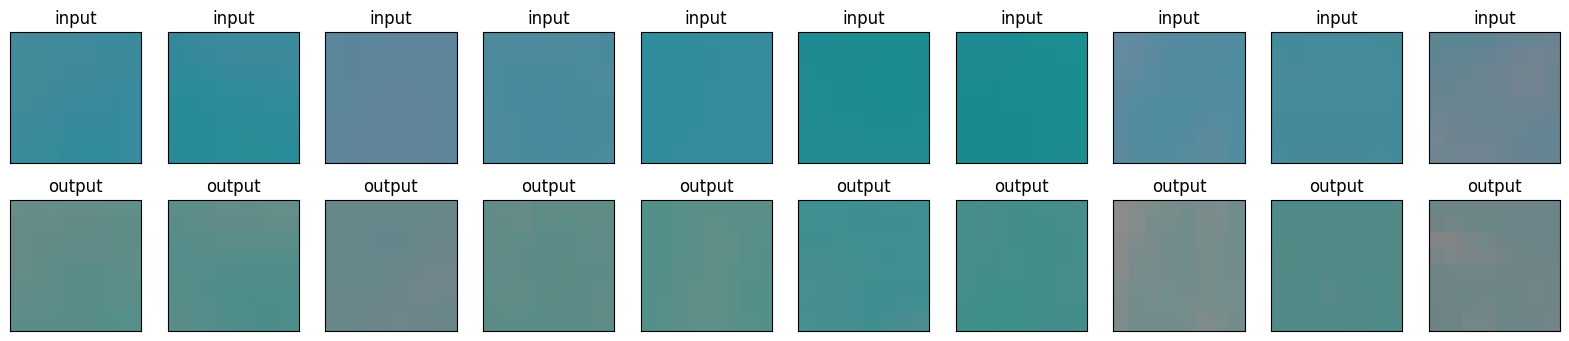

In [6]:
N = 15000
n = 10
plt.figure(figsize=(20, 4))
for i in range(0,10):
    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+N]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Creating the Unet model

In [7]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def unet_model(input_shape=(size, size, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)

    #conv2 = Conv2D(16, 3, activation='relu', padding='same', strides=2)(conv1)
    #conv2 = Conv2D(16, 3, activation='relu', padding='same')(conv2)

    #conv3 = Conv2D(32, 3, activation='relu', padding='same', strides=2)(conv2)
    #conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv3)

    #conv4 = Conv2D(64, 3, activation='relu', padding='same', strides=2)(conv3)
    #conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)

    #conv5 = concatenate([Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv4), conv3], axis=-1)
    #conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    #conv6 = concatenate([Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv3), conv2], axis=-1)
    #conv6 = Conv2D(16, 3, activation='relu', padding='same')(conv6)

    #conv7 = concatenate([Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv2), conv1], axis=-1)
    #conv7 = Conv2D(8, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    output = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv1)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 3)]         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          896       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 3)           867       
                                                                 
Total params: 11011 (43.01 KB)
Trainable params: 11011 (43.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Unet model

In [8]:

from keras.optimizers import Adam
from tensorflow.keras import layers, losses

opt = Adam(learning_rate=0.0001)
unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=100,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=32)
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'Model/portion only/unet_' + str(model_number) + '_lab')

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'Model/portion only/loss_'+ str(model_number) + '_lab.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'Model/portion only/val_loss_'+ str(model_number)+ '_lab.csv')

Epoch 1/100
575/575 [==============================] - 7s 10ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 2/100
575/575 [==============================] - 8s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/100
575/575 [==============================] - 6s 10ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
575/575 [==============================] - 7s 13ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
575/575 [==============================] - 6s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
575/575 [==============================] - 7s 12ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
575/575 [==============================] - 7s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/100
575/575 [==============================] - 6s 10ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
575/575 [==============================] - 8s 14ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
575/575 [==============================] - 6s 10ms/step - loss: 0.001

## Testing the model

6/6 [==============================] - 0s 6ms/step


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7bf220fed990>)

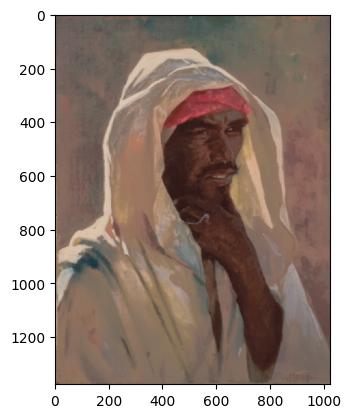

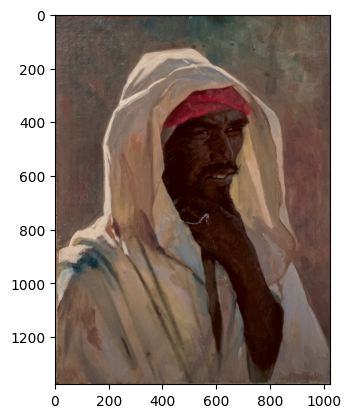

In [9]:
from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

n_size = 8
size = n_size

def lab_rgb_unnormalized(lab_image):
    lab_array = np.array(lab_image/255)# Convert LAB image to numpy array
    lab_array[..., 0] = lab_array[..., 0] * 100.0# Scale LAB values back to their original ranges
    lab_array[..., 1] = (lab_array[..., 1] * 255.0) - 128
    lab_array[..., 2] = (lab_array[..., 2] * 255.0) - 128
    rgb_array_unnormalized = color.lab2rgb(lab_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def AB_rgb_unnormalized(lab_image, test_L):
    lab_array = np.array(lab_image/255)# Convert LAB image to numpy array
    lab_array[..., 0] = test_L #replacing L from the original input
    lab_array[..., 1] = (lab_array[..., 1] * 255.0) - 128
    lab_array[..., 2] = (lab_array[..., 2] * 255.0) - 128
    rgb_array_unnormalized = color.lab2rgb(lab_array)# Convert LAB to RGB colorspace
    rgb_array_unnormalized = (rgb_array_unnormalized * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_image_unnormalized = Image.fromarray(rgb_array_unnormalized, mode='RGB')# Convert RGB array back to image
    return rgb_image_unnormalized

def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data


#----------------READING THE TEST IMAGE--------------------#
filename = str("[08] Conserving a Moroccan Portrait - Before.png")
test = Image.open(file_path+ "Testing/portion only/" + filename).convert('RGB')
test_L = color.rgb2lab(np.array(test))
test_L = test_L[..., 0]
test = rgb_lab_normalized(test)
w_dirty, h_dirty = test.size
#----------------------------------------------------------#

autoencoder = keras.models.load_model(file_path + 'Model/portion only/unet_'+str(n_size)+'_lab')


xx = int(w_dirty/n_size)
final=[]
for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)
    neverbeforeseen = np.array(crop_(im1))
    decoded_imgs = autoencoder.predict(neverbeforeseen)
    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

#----------------TEST ON FULL LAB--------------------#
final_LAB = lab_rgb_unnormalized(final)
final_LAB = np.squeeze(final_LAB)
reconstructed_LAB = Image.fromarray(final_LAB)
reconstructed_LAB.save(file_path + "Testing/portion only/"+"Method_3_"+filename)
plt.figure(), plt.imshow(reconstructed_LAB)

#----------------TEST ON L from input and AB from model--------------------#
final_L_AB = AB_rgb_unnormalized(final, test_L)
final_L_AB = np.squeeze(final_L_AB)
reconstructed_L_AB = Image.fromarray(final_L_AB)
reconstructed_L_AB.save(file_path + "Testing/portion only/"+"Method_4_"+filename)
plt.figure(), plt.imshow(reconstructed_L_AB)

In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to open image and convert to numpy array
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    return np.array(image)

image_path1 = file_path + 'Testing/OUTPUT_[05] Comprimise-d.png'
image_path2 = file_path + "Testing/"+"Method_3_"+str(size)+"LAB_"+filename

# Load images
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Ensure the images have the same dimensions
if image1.shape != image2.shape:
    raise ValueError("Input images must have the same dimensions.")

# Compute SSIM for each channel and average the results
ssim_index_r = ssim(image1[:, :, 0], image2[:, :, 0], data_range=image1[:, :, 0].max() - image1[:, :, 0].min())
ssim_index_g = ssim(image1[:, :, 1], image2[:, :, 1], data_range=image1[:, :, 1].max() - image1[:, :, 1].min())
ssim_index_b = ssim(image1[:, :, 2], image2[:, :, 2], data_range=image1[:, :, 2].max() - image1[:, :, 2].min())

ssim_index_rgb = (ssim_index_r + ssim_index_g + ssim_index_b) / 3

print(f"SSIM for R channel: {ssim_index_r}")
print(f"SSIM for G channel: {ssim_index_g}")
print(f"SSIM for B channel: {ssim_index_b}")
print(f"Average SSIM for RGB image(Method3): {ssim_index_rgb}")


SSIM for R channel: 0.509358346147561
SSIM for G channel: 0.5081811788128479
SSIM for B channel: 0.4024215496836909
Average SSIM for RGB image(Method3): 0.4733203582146999


In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to open image and convert to numpy array
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    return np.array(image)

image_path1 = file_path + 'Testing/OUTPUT_[05] Comprimise-d.png'
image_path2 = file_path + "Testing/"+"Method_4_"+str(size)+"L_AB_"+filename

# Load images
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Ensure the images have the same dimensions
if image1.shape != image2.shape:
    raise ValueError("Input images must have the same dimensions.")

# Compute SSIM for each channel and average the results
ssim_index_r = ssim(image1[:, :, 0], image2[:, :, 0], data_range=image1[:, :, 0].max() - image1[:, :, 0].min())
ssim_index_g = ssim(image1[:, :, 1], image2[:, :, 1], data_range=image1[:, :, 1].max() - image1[:, :, 1].min())
ssim_index_b = ssim(image1[:, :, 2], image2[:, :, 2], data_range=image1[:, :, 2].max() - image1[:, :, 2].min())

ssim_index_rgb = (ssim_index_r + ssim_index_g + ssim_index_b) / 3

print(f"SSIM for R channel: {ssim_index_r}")
print(f"SSIM for G channel: {ssim_index_g}")
print(f"SSIM for B channel: {ssim_index_b}")
print(f"Average SSIM for RGB image(Method4): {ssim_index_rgb}")


SSIM for R channel: 0.5487580309946481
SSIM for G channel: 0.5692294383749303
SSIM for B channel: 0.4253035732161732
Average SSIM for RGB image(Method4): 0.514430347528584


In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_average_ssim(image1_path, image2_path):
    # Open the images using Pillow
    image1 = Image.open(image1_path).convert('RGB')
    image2 = Image.open(image2_path).convert('RGB')

    # Convert images from RGB to LAB color space using Pillow
    lab_image1 = image1.convert('LAB')
    lab_image2 = image2.convert('LAB')

    # Convert to numpy arrays
    lab_image1 = np.array(lab_image1)
    lab_image2 = np.array(lab_image2)

    # Extract the A and B channels
    a_channel1, b_channel1 = lab_image1[:, :, 1], lab_image1[:, :, 2]
    a_channel2, b_channel2 = lab_image2[:, :, 1], lab_image2[:, :, 2]

    # Compute SSIM for the A channel
    ssim_a = ssim(a_channel1, a_channel2)

    # Compute SSIM for the B channel
    ssim_b = ssim(b_channel1, b_channel2)

    # Average the SSIM values
    average_ssim = (ssim_a + ssim_b) / 2

    return average_ssim

# Paths to the images
image1_path = file_path + 'Testing/OUTPUT_[05] Comprimise-d.png'
image2_path = image_path2 = file_path + "Testing/"+"Method_3_"+str(size)+"LAB_"+filename

# Compute the average SSIM
average_ssim_value = compute_average_ssim(image1_path, image2_path)
print(f"Average SSIM (A and B channels (Method3)): {average_ssim_value}")


Average SSIM (A and B channels (Method3)): 0.4829091381886401


In [ ]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_average_ssim(image1_path, image2_path):
    # Open the images using Pillow
    image1 = Image.open(image1_path).convert('RGB')
    image2 = Image.open(image2_path).convert('RGB')

    # Convert images from RGB to LAB color space using Pillow
    lab_image1 = image1.convert('LAB')
    lab_image2 = image2.convert('LAB')

    # Convert to numpy arrays
    lab_image1 = np.array(lab_image1)
    lab_image2 = np.array(lab_image2)

    # Extract the A and B channels
    a_channel1, b_channel1 = lab_image1[:, :, 1], lab_image1[:, :, 2]
    a_channel2, b_channel2 = lab_image2[:, :, 1], lab_image2[:, :, 2]

    # Compute SSIM for the A channel
    ssim_a = ssim(a_channel1, a_channel2)

    # Compute SSIM for the B channel
    ssim_b = ssim(b_channel1, b_channel2)

    # Average the SSIM values
    average_ssim = (ssim_a + ssim_b) / 2

    return average_ssim

# Paths to the images
image1_path = file_path + 'Testing/OUTPUT_[05] Comprimise-d.png'
image2_path = image_path2 = file_path + "Testing/"+"Method_4_"+str(size)+"L_AB_"+filename

# Compute the average SSIM
average_ssim_value = compute_average_ssim(image1_path, image2_path)
print(f"Average SSIM (A and B channels (Method4)): {average_ssim_value}")


Average SSIM (A and B channels (Method4)): 0.4836187382989704
